### Imports

In [1]:
import os
# os.environ['PATH'] = '/usr/local/cuda-11.6/bin:' + os.environ['PATH']
if 'notebooks' not in os.listdir(os.getcwd()):
    os.chdir('../') #changing directories so that output/gsplat_full etc. exists

from contextlib import redirect_stdout
from video_api import initialize_gaussians
from gaussian_renderer import render
import sys 
import torch 
from PIL import Image
import numpy as np

%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn.functional as F
from utils.mujoco_utils import compute_camera_extrinsic_matrix, compute_camera_intrinsic_matrix
from utils.mujoco_utils import get_canonical_pose, set_xml_light_params, find_non_collision_pose, save_robot_metadata, ControlRobot
import mujoco
from utils.graphics_utils import getWorld2View2, getProjectionMatrix, se3_to_SE3
from IPython.display import Image as IPImage
from moviepy import ImageSequenceClip
from scipy.spatial.transform import Rotation 
import cv2
from torchviz import make_dot
import pandas as pd

from notebooks.utils import Utils


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Functions

### Initialization

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4090'

In [3]:
## ------ Initialize Gaussian Renderer ------ ##
sys.argv = ['']
gaussians, background_color, sample_cameras, kinematic_chain = initialize_gaussians(model_path='./output/p_short_exp_2', bg_color=[0, 0, 0])
pose = gaussians.get_xyz
w2e = torch.mean(gaussians._xyz, 0).clone().detach()

# with torch.no_grad():  # Ensure no gradient tracking for direct modification
    # gaussians._xyz[:] -= torch.mean(gaussians._xyz, 0)  # translation
# print(gaussians._xyz[:, 2])
print(w2e)
T_wt_homogeneous = torch.cat([w2e, torch.tensor([1.0], device='cuda:0')])
example_camera = sample_cameras[0]
P = example_camera.projection_matrix.to('cuda:0')
print(example_camera.world_view_transform)
print("P\n",P)
import math
tanfovx = math.tan(example_camera.FoVx * 0.5)
tanfovy = math.tan(example_camera.FoVy * 0.5)

focal_length_x = example_camera.image_width / (2 * tanfovx)
focal_length_y = example_camera.image_height / (2 * tanfovy)
K = torch.tensor(
    [
        [focal_length_x, 0, example_camera.image_width / 2.0, 0],
        [0, focal_length_y, example_camera.image_height / 2.0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ],
    device="cuda",
)
print("K:\n", K)
print(example_camera.get_camera_center())
# example_camera.image_height = 540
# example_camera.image_width = 960

Config file not found at
self.model_path ./output/p_short_exp_2
[Scene] Loading trained Gaussian model at iteration 60000
[Scene] Loading robot model from model path
tensor([-1.6442e-05,  1.2671e-04, -4.7070e-01], device='cuda:0')
tensor([[ 0.3584,  0.5221,  0.7740,  0.0000],
        [-0.9336,  0.2004,  0.2971,  0.0000],
        [-0.0000, -0.8290,  0.5592,  0.0000],
        [-0.0019, -0.4111,  0.5770,  1.0000]])
P
 tensor([[ 2.4328,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  2.4328,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0001,  1.0000],
        [ 0.0000,  0.0000, -0.0100,  0.0000]], device='cuda:0')
K:
 tensor([[311.3939,   0.0000, 128.0000,   0.0000],
        [  0.0000, 311.3939, 128.0000,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], device='cuda:0')
tensor([-0.2313, -0.0909, -0.6635])


/home/iulian/chole_ws/src/drrobot/scene/gaussian_model.py:304: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lrs = torch.load(os.path.join(os.path.dirname(path), 'lrs.pth'))

tensor(14462, device='cuda:0')
tensor(22428, device='cuda:0')


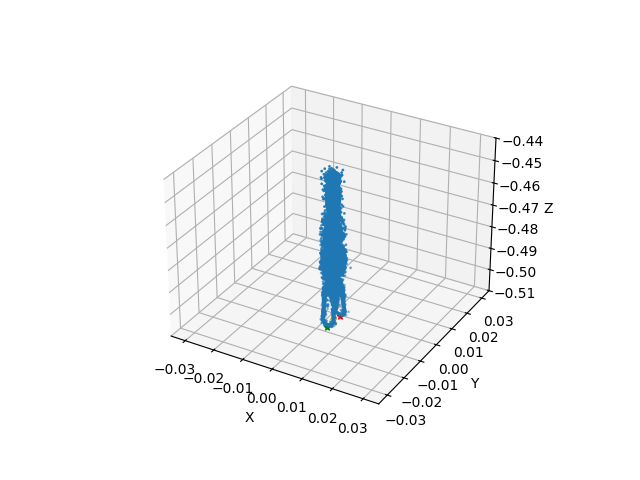

In [4]:
## plot the canonical gaussian
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-0.035, 0.035)
ax.set_ylim(-0.035, 0.035)
ax.set_zlim(-0.51, -0.44)
ax.scatter(gaussians._xyz[:, 0].detach().cpu().numpy(), gaussians._xyz[:, 1].detach().cpu().numpy(), gaussians._xyz[:, 2].detach().cpu().numpy(), s=1)

## find the point with min z value and its index
min_z, min_z_idx = torch.min(gaussians._xyz[:, 2], 0)
print(min_z_idx)
ax.scatter(gaussians._xyz[min_z_idx, 0].detach().cpu().numpy(), gaussians._xyz[min_z_idx, 1].detach().cpu().numpy(), gaussians._xyz[min_z_idx, 2].detach().cpu().numpy(), s=20, c='r', marker='*')

## find the point with abs value of x < 0.0005 and z < -0.5 with min y value and its index
filtered_indices = torch.logical_and(torch.abs(gaussians._xyz[:, 0]) < 0.0005, gaussians._xyz[:, 2] < -0.5)
filtered_points = gaussians._xyz[filtered_indices]
min_y, min_y_idx = torch.min(filtered_points[:, 1], 0)
original_min_y_idx = torch.nonzero(filtered_indices)[min_y_idx][0]
print(original_min_y_idx)
ax.scatter(gaussians._xyz[original_min_y_idx, 0].detach().cpu().numpy(), gaussians._xyz[original_min_y_idx, 1].detach().cpu().numpy(), gaussians._xyz[original_min_y_idx, 2].detach().cpu().numpy(), s=20, c='g', marker='*')

## find middle point between the two points
middle_point = (gaussians._xyz[min_z_idx] + gaussians._xyz[original_min_y_idx]) / 2
ax.scatter(middle_point[0].detach().cpu().numpy(), middle_point[1].detach().cpu().numpy(), middle_point[2].detach().cpu().numpy(), s=20, c='y', marker='x')


plt.show()


In [5]:
## ------ Configure Camera Parameters ------ ##
example_camera = sample_cameras[0]

## Customize camera parameters
cam = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(cam)
cam.distance = 0.1
cam.azimuth = -20.0
cam.elevation = -20
cam.lookat = (0,0,-0.4)
w2v = compute_camera_extrinsic_matrix(cam)

print("Extrinsics:\n", w2v)

# w2v = getWorld2View2(extrinsic[:3, :3].T, extrinsic[:3, 3], np.array([0.0, 0.0, 0.0]), 1.0)
# print(w2v)

## rotate the view
theta = -np.pi/2  # 90 degrees in radians
R_z = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta),  np.cos(theta), 0],
    [0,              0,             1]
])

R = w2v[:3, :3]
t = w2v[:3, 3]

# Apply translation
t[0] = -0.5
t[1] = 0.02
# t[0] -= 0.06
# t[1] += 0.03

# Apply the rotation
R_rotated = R_z @ R  # Rotate the original rotation matrix
t_rotated = t  # Rotate the translation vector

# Combine back into a transformation matrix
T_rotated = np.eye(4)
T_rotated[:3, :3] = R_rotated
T_rotated[:3, 3] = t_rotated

T_rotated_torch = torch.tensor(T_rotated, dtype=example_camera.world_view_transform.dtype).transpose(0, 1).to(example_camera.data_device)

example_camera.world_view_transform = T_rotated_torch
print("TWV:\n", example_camera.world_view_transform)
P = example_camera.projection_matrix.to('cuda:0')
P = example_camera.full_proj_transform.to('cuda:0')
print(P)
print(example_camera.get_projection_matrix())
center = example_camera.camera_center.to('cuda:0')
print(example_camera.get_camera_center())


Extrinsics:
 [[-3.42020143e-01 -9.39692621e-01  0.00000000e+00  6.93889390e-18]
 [-3.21393805e-01  1.16977778e-01 -9.39692621e-01 -3.75877048e-01]
 [ 8.83022222e-01 -3.21393805e-01 -3.42020143e-01 -3.68080573e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
TWV:
 tensor([[-3.2139e-01,  3.4202e-01,  8.8302e-01,  0.0000e+00],
        [ 1.1698e-01,  9.3969e-01, -3.2139e-01,  0.0000e+00],
        [-9.3969e-01, -5.7540e-17, -3.4202e-01,  0.0000e+00],
        [-5.0000e-01,  2.0000e-02, -3.6808e-02,  1.0000e+00]])
tensor([[ 0.8718,  1.2700,  0.7741,  0.7740],
        [-2.2712,  0.4875,  0.2971,  0.2971],
        [ 0.0000, -2.0169,  0.5592,  0.5592],
        [-0.0047, -1.0000,  0.5671,  0.5770]], device='cuda:0')
tensor([[-7.8188e-01,  8.3205e-01,  8.8311e-01,  8.8302e-01],
        [ 2.8458e-01,  2.2861e+00, -3.2143e-01, -3.2139e-01],
        [-2.2861e+00, -1.3998e-16, -3.4205e-01, -3.4202e-01],
        [-1.2164e+00,  4.8655e-02, -4.6813e-02, -3.6808e-02]])
tensor([-0.1

['pitch', 'right_jaw', 'passive_1', 'left_jaw', 'passive_2']
[Cache] get_canonical_pose


/home/iulian/miniforge3/envs/dr_2/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


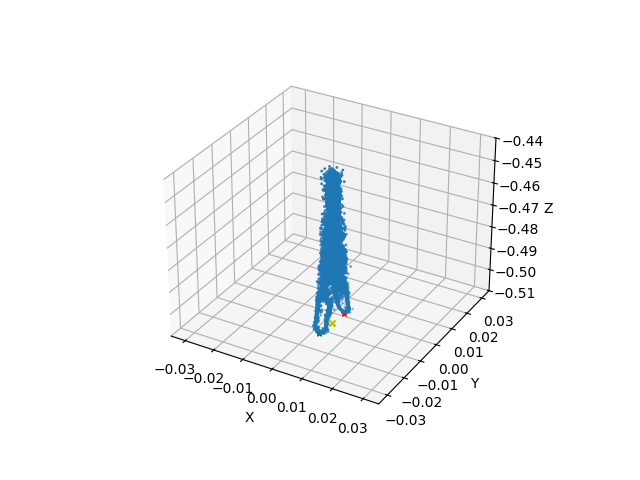

w2v: tensor([[-3.2139e-01,  3.4202e-01,  8.8302e-01,  0.0000e+00],
        [ 1.1698e-01,  9.3969e-01, -3.2139e-01,  0.0000e+00],
        [-9.3969e-01, -5.7540e-17, -3.4202e-01,  0.0000e+00],
        [-5.0000e-01,  2.0000e-02, -3.6808e-02,  1.0000e+00]],
       requires_grad=True)


In [6]:
## ------ Render Init Gaussian ------ ##
n = len(kinematic_chain.get_joint_parameter_names())  
print(kinematic_chain.get_joint_parameter_names())  
# home_pose = [0.2, 0.3, 0.222, -0.203, 0.257]
home_pose = [0.0, 0.125, 0.222, -0.203, 0.257]
# example_camera = sample_cameras[0]
# home_pose = [0.0, 0.125, 0.222, -0.203, 0.257]
example_camera.joint_pose = torch.tensor(home_pose,).requires_grad_(True)
example_camera.world_view_transform.requires_grad_(True)
# with torch.no_grad():  # Ensure no gradient tracking for direct modification
#     gaussians._xyz[:, 0] -= 0.01  # translation

theta = -np.pi /2   # Example: 45-degree rotation
R_z = torch.tensor([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta),  np.cos(theta), 0],
    [0,              0,             1]
], dtype=torch.float32, device=gaussians._xyz.device)

R_x = torch.tensor([
    [1, 0, 0],
    [0, np.cos(theta), -np.sin(theta)],
    [0, np.sin(theta), np.cos(theta)]
], dtype=torch.float32, device=gaussians._xyz.device)

# gaussians._xyz = torch.matmul(gaussians._xyz, R_z.T)  # Transpose R_z for proper multiplication
result = render(example_camera, gaussians, background_color)

# fig = plt.figure()

# Use the raw alpha channel as a continuous mask
mask = result['render']  # Continuous alpha values, directly from render_alphas
pc = result['pc'].detach().cpu().numpy() # Point cloud, directly from render_points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-0.035, 0.035)
ax.set_ylim(-0.035, 0.035)
ax.set_zlim(-0.51, -0.44)
ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=1)

## plot min z point
ax.scatter(pc[min_z_idx, 0], pc[min_z_idx, 1], pc[min_z_idx, 2], s=20, c='r', marker='*')

## plot min y point
ax.scatter(pc[original_min_y_idx, 0], pc[original_min_y_idx, 1], pc[original_min_y_idx, 2], s=20, c='g', marker='*')

middle_point = (pc[min_z_idx] + pc[original_min_y_idx]) / 2
ax.scatter(middle_point[0], middle_point[1], middle_point[2], s=20, c='y', marker='x')

plt.show()


frame = mask  # Use the mask directly without clamping or thresholding

# Display the mask (optional, normalized for visualization)
# Utils.display_render(torch.clamp(mask, 0, 1))

print("w2v:", example_camera.world_view_transform)
# frame.sum().backward()
# print('Sum of joint gradients:', example_camera.joint_pose.grad.sum())
# print('Sum of camera gradients:', example_camera.world_view_transform.grad.sum())

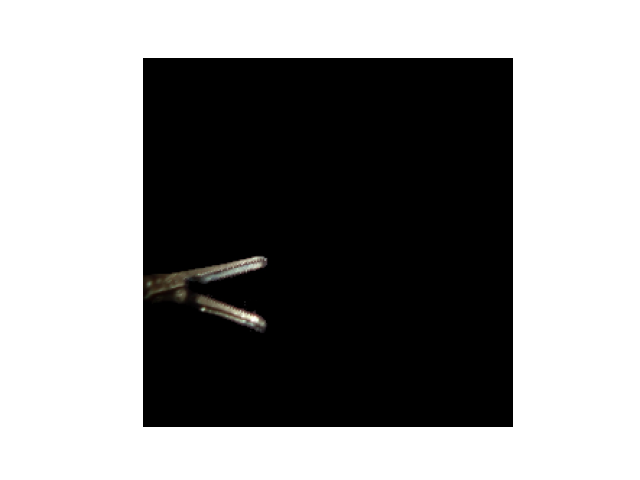

Reference image shape: torch.Size([3, 256, 256])
744.4832153320312


In [7]:
## ------ Display Reference Image ------ ##
original_image_path = "/home/iulian/chole_ws/src/sam2/data/tissue_18/grab/000000.jpg"  # Path to your reference image
reference_image_path = "/home/iulian/chole_ws/src/sam2/data/tissue_18/segment_results/frame_0_id_1.jpg"  # Path to your reference image
# original_image_path = "/home/iulian/chole_ws/src/sam2/data/tissue_75/grab/000000.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/chole_ws/src/sam2/data/tissue_75/segment_results/frame_0_id_1.jpg"  # Path to your reference image
# original_image_path = "/home/iulian/chole_ws/src/sam2/data/tissue_80/grab/000000.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/chole_ws/src/sam2/segment_results/frame_0_id_1.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/mask_2.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/segmented_tool_8_0.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/chole_ws/data/base_chole_clipping_cutting/tissue_77/1_grabbing_gallbladder/20240907-090634-569257/left_img_dir/frame000017_left.jpg"  # Path to your reference image

fig = plt.figure()


## read the image
original_image = Image.open(original_image_path).convert('RGB')
reference_image = Image.open(reference_image_path).convert('RGB')

## crop the image to be square
# reference_image = np.array(reference_image)[:540, :540]
reference_image = torch.tensor(np.array(reference_image) / 255.0).permute(2, 0, 1).float().to("cuda")  # Normalized [0, 1]
reference_image = Utils.pad_to_match_aspect(reference_image, 1.0)

reference_image = F.interpolate(reference_image.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)

plt.imshow(reference_image.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()
print("Reference image shape:", reference_image.shape)  # Expected: [3, H, W]

# Calculate target aspect ratio (reference image)
target_aspect_ratio = reference_image.shape[2] / reference_image.shape[1]

# Pad the rendered image to match the aspect ratio of the reference image
normalization_factor = torch.sum(reference_image ** 2).item()  # Sum of squared pixel values
print(normalization_factor)

### Optimization

In [8]:
## ------ Setting Optimization Parameters ------ ##

# Initialize parameters
joint_pose_result = torch.tensor(home_pose, requires_grad=True, device="cuda")  # Initial joint pose
world_view_transform_result = example_camera.world_view_transform.clone().detach().to("cuda").requires_grad_(True) # Initial camera transform
print(joint_pose_result)
print(world_view_transform_result)
# Define different learning rates
# joint_pose_lr = 2e-4
# world_transform_lr = 1e-4

joint_pose_lr = 1e-3
rotation_lr = 1e-4
translation_lr = 1e-4
# Initialize the optimizer with parameter groups
# optimizer = torch.optim.Adam([
#     {"params": joint_pose_result, "lr": joint_pose_lr},
#     {"params": world_view_transform_result, "lr": world_transform_lr}
# ])
# quat, translation = decompose_homogeneous_matrix_quaternion(example_camera.world_view_transform.clone().detach().cpu())
# quat = torch.nn.Parameter(quat, requires_grad=True)
# translation = torch.nn.Parameter(translation, requires_grad=True)

# Define optimizer with separate learning rates
optimizer = torch.optim.Adam([
    {"params": joint_pose_result, "lr": joint_pose_lr},
    {"params": world_view_transform_result, "lr": translation_lr},
    # {"params": quat, "lr": rotation_lr},
    # {"params": translation, "lr": translation_lr}
])
num_iterations = 500

loss_fn = torch.nn.MSELoss()
video = []


tensor([ 0.0000,  0.1250,  0.2220, -0.2030,  0.2570], device='cuda:0',
       requires_grad=True)
tensor([[-3.2139e-01,  3.4202e-01,  8.8302e-01,  0.0000e+00],
        [ 1.1698e-01,  9.3969e-01, -3.2139e-01,  0.0000e+00],
        [-9.3969e-01, -5.7540e-17, -3.4202e-01,  0.0000e+00],
        [-5.0000e-01,  2.0000e-02, -3.6808e-02,  1.0000e+00]], device='cuda:0',
       requires_grad=True)


Loss change is less than threshold. Count = 1
Loss change is less than threshold. Count = 2
Loss change is less than threshold. Count = 3
Loss change is less than threshold. Count = 4
Loss change is less than threshold. Count = 5
Loss change is less than threshold. Count = 6
Loss change is less than threshold. Count = 7
Loss change is less than threshold. Count = 8
Loss change is less than threshold. Count = 9
Loss change is less than threshold. Count = 10
Early stopping


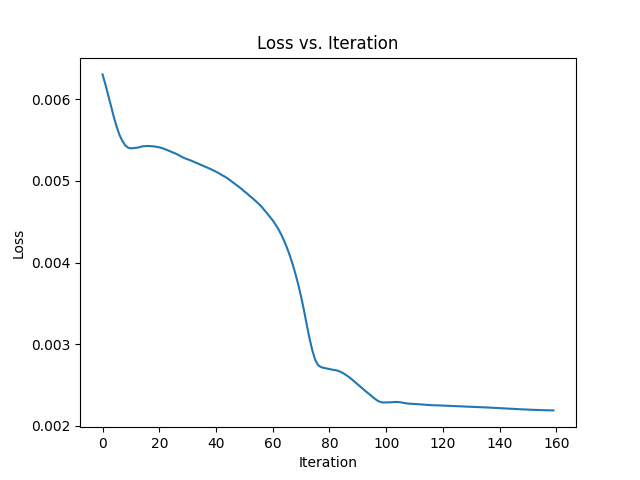

Final joint pose: tensor([-0.0297,  0.1860,  0.1538, -0.1906,  0.2623], device='cuda:0',
       requires_grad=True)
Final camera transform: tensor([[-0.3293,  0.3448,  0.8790,  0.0000],
        [ 0.1243,  0.9387, -0.3216,  0.0000],
        [-0.9360,  0.0034, -0.3520,  0.0000],
        [-0.5015,  0.0152, -0.0292,  1.0000]], device='cuda:0',
       requires_grad=True)


In [9]:

fig = plt.figure()
# Optimization loop
video, joint_pose_result, world_view_transform_result, pc= Utils.optimization_w2v(example_camera, gaussians, background_color, reference_image, loss_fn, optimizer, joint_pose_result, world_view_transform_result, num_iterations=num_iterations, plot=True)
# video, joint_pose_result, world_view_transform_result, euler_angles_result, translation_result = optimization_quat(example_camera, gaussians, background_color, reference_image, loss_fn, optimizer, joint_pose_result, world_view_transform_result, quat, translation, num_iterations=num_iterations)

# Final results
print("Final joint pose:", joint_pose_result)
print("Final camera transform:", world_view_transform_result)


MoviePy - Building file pose_est_init.gif with imageio.


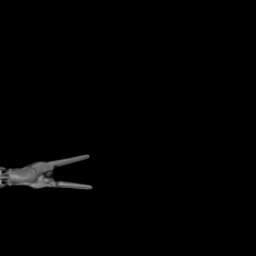

In [10]:
## ------ Save the video ------ ##
Utils.make_video(video, filename="pose_est_init", fps=10)
IPImage(filename="pose_est_init.gif")


(-0.5, 255.5, 255.5, -0.5)

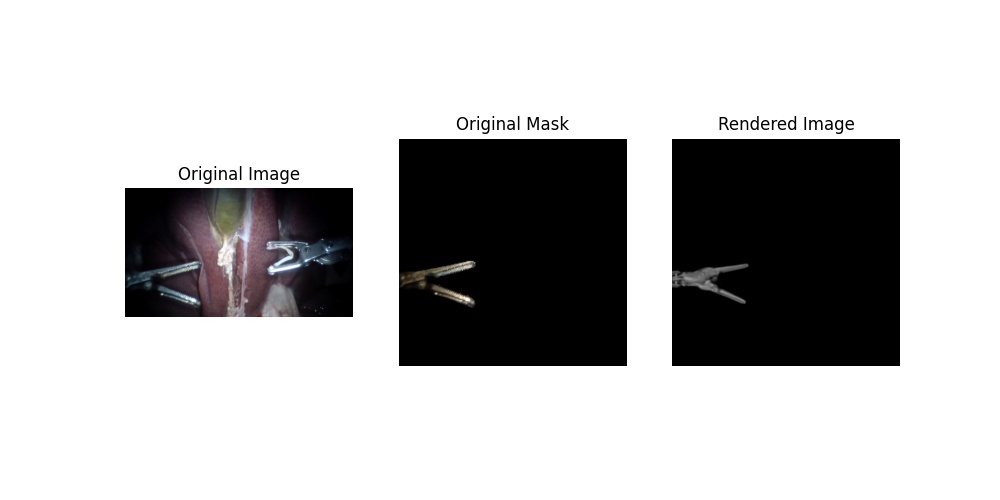

In [11]:
## ------ Compare the final rendered image and the reference image------ ##

final_render = torch.clamp(render(example_camera, gaussians, background_color)['render'], 0, 1)

# display_render(final_render)
padded_rendered_image = Utils.pad_to_match_aspect(final_render, target_aspect_ratio)
## subplot to show the original image and the rendered image
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 3, 1)
ax.set_title("Original Image")
ax.imshow(original_image)
ax.axis('off')

ax = plt.subplot(1, 3, 2)
ax.set_title("Original Mask")
ax.imshow(reference_image.permute(1, 2, 0).cpu().numpy())
ax.axis('off')

subplot = plt.subplot(1, 3, 3)
subplot.set_title("Rendered Image")
subplot.imshow(final_render.detach().permute(1, 2, 0).cpu().numpy())
subplot.axis('off')


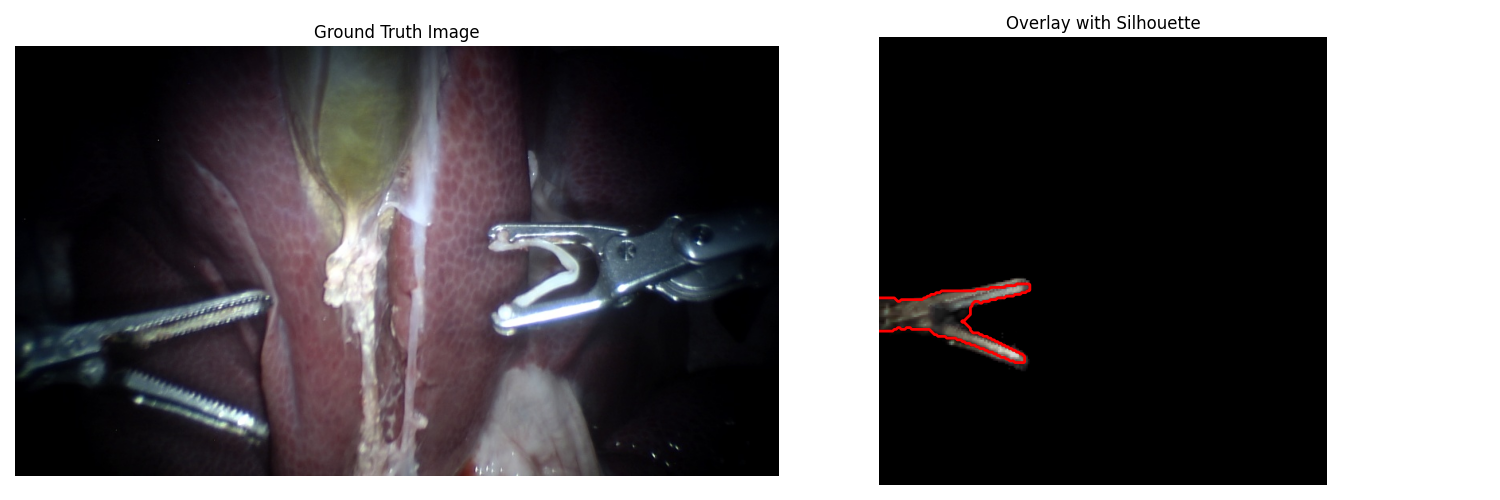

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

## ------ Compare the final rendered image and the reference image with overlay ------ ##
final_render = torch.clamp(render(example_camera, gaussians, background_color)['render'], 0, 1)
padded_rendered_image = Utils.pad_to_match_aspect(final_render, target_aspect_ratio)

# Convert images for visualization
rendered_image_np = padded_rendered_image.detach().permute(1, 2, 0).cpu().numpy()
ground_truth_image_np = reference_image.permute(1, 2, 0).cpu().numpy()

# Alpha blending (overlay with transparency)
alpha = 0.3  # Transparency factor
blended_image = (alpha * rendered_image_np + (1 - alpha) * ground_truth_image_np)

# Extract silhouette using threshold and contour detection
rendered_mask = np.any(rendered_image_np > 0.05, axis=-1)  # Threshold for silhouette detection
contours = measure.find_contours(rendered_mask.astype(float), 0.5)

## Plot the images
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Ground Truth
ax = axs[0]
ax.set_title("Ground Truth Image")
ax.imshow(original_image)
ax.axis('off')

# Mask (if required)
# ax = axs[1]
# ax.set_title("Original Mask")
# ax.imshow(reference_image.permute(1, 2, 0).cpu().numpy())
# ax.axis('off')

# # Rendered Image
# ax = axs[2]
# ax.set_title("Rendered Image")
# ax.imshow(rendered_image_np)
# ax.axis('off')

# Blended Visualization with Silhouette
ax = axs[1]
ax.set_title("Overlay with Silhouette")
ax.imshow(blended_image)

# Draw silhouette contours on the blended image
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

ax.axis('off')

plt.tight_layout()
plt.show()


Number of images: 115
MoviePy - Building file mask_test.gif with imageio.


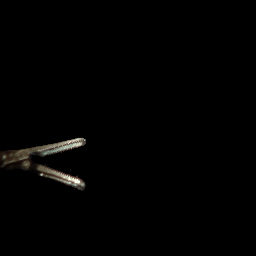

In [13]:
## ------ Iterate through the video ------ ##

# Path to the folder containing images
image_folder = "/home/iulian/chole_ws/src/sam2/data/tissue_18/segment_results/"

# Count the number of files and prepare the image list
imgs = []
image_num = Utils.count_files(image_folder)
for i in range(int(image_num)):
    img_path = os.path.join(image_folder, f"frame_{i}_id_1.jpg")
    img = Image.open(img_path)
    # img = np.array(img)[:540, :540]

    img = torch.tensor(np.array(img) / 255.0).permute(2, 0, 1).float().to("cuda")  # Normalized [0, 1]
    img = Utils.pad_to_match_aspect(img, 1.0)
    
    img = F.interpolate(img.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)
    imgs.append(img)

# Check number of images
print("Number of images:", len(imgs))

Utils.make_video(imgs, filename="mask_test")

IPImage(filename="mask_test.gif")
# plt.imshow(imgs[30].permute(1,2,0).detach().cpu().numpy())
# plt.axis('off')

In [14]:


def optimize_and_tune(
    example_camera, gaussians, background_color, imgs, loss_fn, joint_pose_result,
    world_view_transform_result, ee_l_qpos, initial_lr=1e-3, initial_iterations=30,
    max_epochs=10, error_threshold=0.001, decay_factor=0.5, lr_min=1e-6
):
    """
    Iteratively tunes num_iterations and learning rates to minimize errors.
    
    Args:
        example_camera: Camera object for rendering.
        gaussians: Gaussian object for rendering.
        background_color: Background color for rendering.
        imgs: List of reference images for optimization.
        loss_fn: Loss function.
        joint_pose_result: Initial joint pose parameter.
        world_view_transform_result: Initial world view transform parameter.
        ee_l_qpos: Ground truth trajectory (numpy array).
        initial_lr: Initial learning rate.
        initial_iterations: Initial number of iterations.
        max_epochs: Maximum number of tuning epochs.
        error_threshold: Error threshold for stopping.
        decay_factor: Factor to decay learning rate and iterations.
        lr_min: Minimum learning rate.

    Returns:
        Tuple of tuned parameters, errors, and final visualization.
    """
    best_errors = None
    best_config = None
    current_lr = initial_lr
    current_iterations = initial_iterations

    for epoch in range(max_epochs):
        print(f"Epoch {epoch + 1}/{max_epochs}")
        optimizer = torch.optim.Adam([
            {"params": joint_pose_result, "lr": current_lr},
            {"params": world_view_transform_result, "lr": current_lr}
        ])

        joint_pose_results = []
        world_view_transform_results = []
        results = []

        for img in imgs:
            video, joint_pose_result, world_view_transform_result = optimization_w2v(
                example_camera, gaussians, background_color, img, loss_fn, optimizer,
                joint_pose_result, world_view_transform_result, num_iterations=current_iterations
            )
            joint_pose_results.append(joint_pose_result.clone().detach())
            world_view_transform_results.append(world_view_transform_result.clone().detach())

        trans_init = world_view_transform_results[0][3, :3].detach().cpu().numpy()
        for r in world_view_transform_results:
            res = r[3, :3].detach().cpu().numpy()
            res = trans_init - res
            results.append(res)

        # Compute errors
        errors = []
        for i in range(len(ee_l_qpos)):
            error = np.linalg.norm(ee_l_qpos[i, :3] - results[i][:3])
            errors.append(error)
        
        mean_error = np.mean(errors)
        print(f"Mean error: {mean_error}")

        # Update best configuration if errors improve
        if best_errors is None or mean_error < np.mean(best_errors):
            best_errors = errors
            best_config = (current_lr, current_iterations)

        # Adjust learning rates and iterations if error is not improving significantly
        if mean_error < error_threshold:
            print("Error threshold reached. Stopping optimization.")
            break
        elif epoch > 0 and mean_error >= np.mean(best_errors):
            current_lr = max(current_lr * decay_factor, lr_min)
            current_iterations = int(current_iterations * (1 + decay_factor))
            print(f"Adjusting learning rate to {current_lr} and iterations to {current_iterations}.")

    # Final visualization
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    for res in results:
        ax.scatter(res[0], res[1], res[2], c="b")
    ax.scatter(ee_l_qpos[:, 0], ee_l_qpos[:, 1], ee_l_qpos[:, 2], c="r")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(-90, 90)
    plt.title("Relative action trajectory")
    plt.show()

    plt.plot(best_errors, label="Best Errors")
    plt.xlabel("Frame")
    plt.ylabel("Error")
    plt.title("Error between the estimated and the ground truth")
    plt.legend()
    plt.show()

    return best_config, best_errors


In [15]:

# ## read the csv file
# ee_csv_path = "/home/iulian/chole_ws/src/sam2/data/tissue_75/grab/ee_csv.csv"
# ee_csv = pd.read_csv(ee_csv_path)
# header_name_qpos_psm1 = ["psm1_pose.position.x", "psm1_pose.position.y", "psm1_pose.position.z",
#                         "psm1_pose.orientation.x", "psm1_pose.orientation.y", "psm1_pose.orientation.z", "psm1_pose.orientation.w",
#                         "psm1_jaw"]

# header_name_qpos_psm2 = ["psm2_pose.position.x", "psm2_pose.position.y", "psm2_pose.position.z",
#                         "psm2_pose.orientation.x", "psm2_pose.orientation.y", "psm2_pose.orientation.z", "psm2_pose.orientation.w",
#                         "psm2_jaw"]

# ee_l_qpos = ee_csv[header_name_qpos_psm2].to_numpy()
# ee_l_qpos_init = ee_l_qpos[0]
# ## normalize the data (substract with the initial pose)
# ee_l_qpos = ee_l_qpos - ee_l_qpos_init

# best_config, best_errors = optimize_and_tune(
#     example_camera, gaussians, background_color, imgs, loss_fn, joint_pose_result,
#     world_view_transform_result, ee_l_qpos, initial_lr=1e-3, initial_iterations=10,
#     max_epochs=10, error_threshold=0.001, decay_factor=0.5, lr_min=1e-6
# )

In [16]:
# Initialize parameters
joint_pose_results = []
world_view_transform_results = []
videos = []
euler_results = []
trans_results = []
pc_results = {}
# Optimization loop
num_iterations = 15
# Define different learning rates
# joint_pose_lr = 5e-4
# rotation_lr = 1
# translation_lr = 3e-5

joint_pose_lr = 8e-4
translation_lr = 8e-5
# Initialize the optimizer with parameter groups
# optimizer = torch.optim.Adam([
#     {"params": joint_pose_result, "lr": joint_pose_lr},
#     {"params": world_view_transform_result, "lr": world_transform_lr}
# ])
# euler_angles, translation = decompose_homogeneous_matrix(example_camera.world_view_transform.clone().detach().cpu())
# euler_angles = torch.nn.Parameter(euler_angles, requires_grad=True)
# translation = torch.nn.Parameter(translation, requires_grad=True)

# Define optimizer with separate learning rates
optimizer = torch.optim.Adam([
    {"params": joint_pose_result, "lr": joint_pose_lr},
    {"params": world_view_transform_result, "lr": translation_lr},
    # {"params": euler_angles, "lr": rotation_lr},
    # {"params": translation, "lr": translation_lr}
])
for n, img in enumerate(imgs):
    ## call the optimization function
    video, joint_pose_result, world_view_transform_result, pc = Utils.optimization_kalman(example_camera, gaussians, background_color, img, loss_fn, optimizer, joint_pose_result, world_view_transform_result, num_iterations=num_iterations)
    # video, joint_pose_result, world_view_transform_result, pc = Utils.optimization_w2v(example_camera, gaussians, background_color, img, loss_fn, optimizer, joint_pose_result, world_view_transform_result, num_iterations=num_iterations)
    # video, joint_pose_result, world_view_transform_result, euler_result, trans_result = optimization_quat(example_camera, gaussians, background_color, img, loss_fn, optimizer, joint_pose_result, world_view_transform_result, quat, translation, num_iterations=num_iterations)
    
    joint_pose_results.append(joint_pose_result.clone().detach())
    world_view_transform_results.append(world_view_transform_result.clone().detach())
    pc_results[n] = pc.detach().cpu().numpy()

    # euler_results.append(euler_result.clone().detach())
    # trans_results.append(trans_result.clone().detach())
    videos.append(video[-1])    # append the last frame of the video

# # Final results
# print("Final joint pose:", joint_pose_result)
# print("Final camera transform:", world_view_transform_result)


Loss change is below threshold. Count = 1
Loss change is below threshold. Count = 2
Loss change is below threshold. Count = 3
Loss change is below threshold. Count = 4
Loss change is below threshold. Count = 5
Loss change is below threshold. Count = 6
Loss change is below threshold. Count = 7
Loss change is below threshold. Count = 8
Loss change is below threshold. Count = 1
Loss change is below threshold. Count = 2
Loss change is below threshold. Count = 3
Loss change is below threshold. Count = 4
Loss change is below threshold. Count = 5
Loss change is below threshold. Count = 6
Loss change is below threshold. Count = 7
Loss change is below threshold. Count = 8
Loss change is below threshold. Count = 9
Loss change is below threshold. Count = 1
Loss change is below threshold. Count = 2
Loss change is below threshold. Count = 3
Loss change is below threshold. Count = 4
Loss change is below threshold. Count = 5
Loss change is below threshold. Count = 6
Loss change is below threshold. Co

In [17]:
print(world_view_transform_results[0])
print(world_view_transform_results[10])
print(world_view_transform_results[20])

tensor([[-0.3296,  0.3451,  0.8788,  0.0000],
        [ 0.1248,  0.9385, -0.3218,  0.0000],
        [-0.9358,  0.0036, -0.3524,  0.0000],
        [-0.5012,  0.0153, -0.0294,  1.0000]], device='cuda:0')
tensor([[-0.3318,  0.3479,  0.8768,  0.0000],
        [ 0.1284,  0.9375, -0.3234,  0.0000],
        [-0.9346,  0.0053, -0.3558,  0.0000],
        [-0.5006,  0.0161, -0.0312,  1.0000]], device='cuda:0')
tensor([[-0.3341,  0.3517,  0.8745,  0.0000],
        [ 0.1329,  0.9361, -0.3256,  0.0000],
        [-0.9331,  0.0074, -0.3595,  0.0000],
        [-0.4990,  0.0161, -0.0314,  1.0000]], device='cuda:0')


MoviePy - Building file tracking_sequence_kalman.gif with imageio.


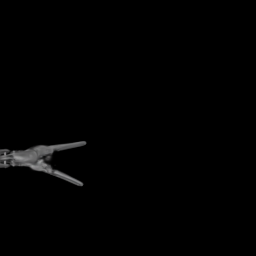

In [18]:
## ------ Save the video ------ ##
Utils.make_video(videos, "tracking_sequence_kalman")
IPImage(filename="tracking_sequence_kalman.gif")
# plt.figure()
# plt.imshow(videos[30].permute(1,2,0).detach().cpu().numpy())
# plt.axis('off')


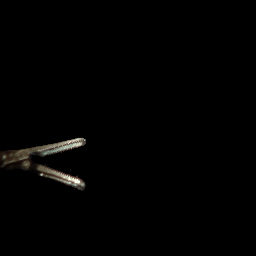

In [19]:
IPImage(filename="mask_test.gif")


MoviePy - Building file tracking_sequence_test_overlay.gif with imageio.


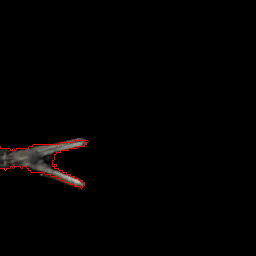

In [20]:
def make_video_overlay(video1, video2, filename, fps=30):
    video1 = Utils.process_video(video1)
    video2 = Utils.process_video(video2)
    video = []
    for i in range(len(video1)):
        overlay = cv2.addWeighted(video1[i], 0.5, video2[i], 0.5, 0)
        rendered_mask = np.any(video1[i] > 0.05, axis=-1)  # Threshold for silhouette detection
        contours = measure.find_contours(rendered_mask.astype(float), 0.5)
        # Draw the contours on the overlay
        for contour in contours:
            overlay[np.round(contour[:, 0]).astype(int), np.round(contour[:, 1]).astype(int)] = [255, 0, 0]

        video.append(overlay)

    clip = ImageSequenceClip(list(video), fps=fps)
    clip.write_gif(f"{filename}.gif")

make_video_overlay(videos, imgs, filename="tracking_sequence_test_overlay")
IPImage(filename="tracking_sequence_test_overlay.gif")

In [21]:
trans_results = []
T_tc_list = []

P = sample_cameras[2].projection_matrix
# P = K.inverse()
# P = example_camera.projection_matrix
# P[0,0] = 30.0
# P[1,1] = 30.0
# P[0,2] = -5.0
# P[1,2] = 10.0
# P[2,2] = 1.0
# P[3,2] = 0.0
# print(P)
tool_poses = []
image_width = 256
image_height = 256
original_image_width = 960
original_image_height = 540

# print("TWC:", world_view_transform_results[0].T)
# print(torch.inverse(world_view_transform_results[0]))

def invert_T(T):
    R = T[..., :3, :3]
    t = T[..., :3, [-1]]
    R_inv = R.transpose(-2, -1)
    t_inv = - R_inv @ t
    T_inv = T.clone()
    T_inv[..., :3, :3] = R_inv
    T_inv[..., :3, [-1]] = t_inv
    return T_inv

for n, w in enumerate(world_view_transform_results):

    ## calculate middle point
    middle_point = (pc_results[n][min_z_idx] + pc_results[n][original_min_y_idx]) / 2

    T_wt_homogeneous = torch.cat([torch.tensor(middle_point, device='cuda:0'), torch.tensor([1.0], device='cuda:0')])


    # T_wc = w.transpose(1, 0)
    T_wc = w  #.transpose(1, 0)

    # Inverse of the world to camera transformation matrix (to transform from world to camera)
    T_wc_inv = invert_T(T_wc.transpose(1, 0))
    # print("TWC inv\n", T_wc_inv)

    # Calculate the position of the surgical tool in the camera frame
    T_tc_homogeneous = T_wt_homogeneous @ T_wc
    T_tc_homogeneous_real = T_wc_inv @ T_wt_homogeneous

    # P = example_camera.projection_matrix
    # P = original_camera_matrix
    # print(P)
    projected_pose = P.T.detach().cpu() @ T_tc_homogeneous[:4].detach().cpu()
    # projected_pose = T_tc_homogeneous[:4].detach().cpu() @ P

    # Normalize by the homogeneous coordinate (w) to get 2D image coordinates
    # x_2d = projected_pose[0] / projected_pose[2]
    # y_2d = projected_pose[1] / projected_pose[2]
    x_2d = ((projected_pose[0] / projected_pose[2] + 1) * 0.5) * image_width
    y_2d = ((projected_pose[1] / projected_pose[2] + 1) * 0.5) * image_height
    # x_2d = (x_2d ) * image_width
    # y_2d = (y_2d ) * image_height
    tool_pose = (x_2d, y_2d)
    # Extract the position of the surgical tool in the camera frame (ignoring the homogeneous coordinate)

    T_tc_list.append(T_tc_homogeneous[:3].detach().cpu().numpy())
    # print(T_tc_homogeneous_real[:3].detach().cpu().numpy(), T_tc_homogeneous[:3].detach().cpu().numpy())

    tool_poses.append(tool_pose)

# print("Surgical tool pose relative to the camera frame:", T_tc_list)
# print(P)
# print(T_wc)
# print(tool_poses[0])
# # print(T_tc_list - T_tc_list[0])
# for n in range(len(tool_poses)):
#     print(f"Frame {n}: {tool_poses[n][0] - tool_poses[0][0]}")


# print(torch.matmul())
# trans_results = world_view_transform_results[:][:3, 3]

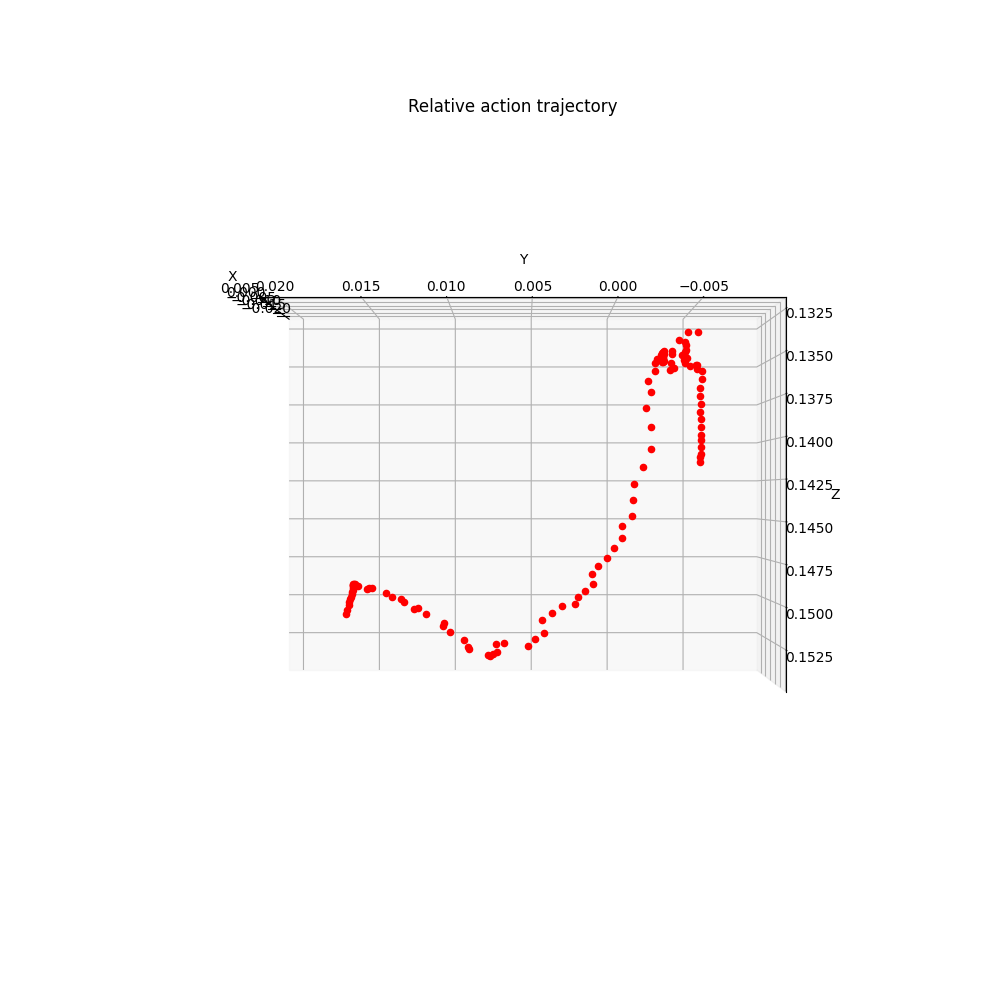

In [22]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for T_tc in T_tc_list:
    ax.scatter(T_tc[0], T_tc[1], T_tc[2], c="r")
ax.view_init(180, 180)
ax.axis('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title("Relative action trajectory") 
plt.show()

tensor(81.1635) tensor(165.6394)
tensor(304.3631) tensor(411.1476)


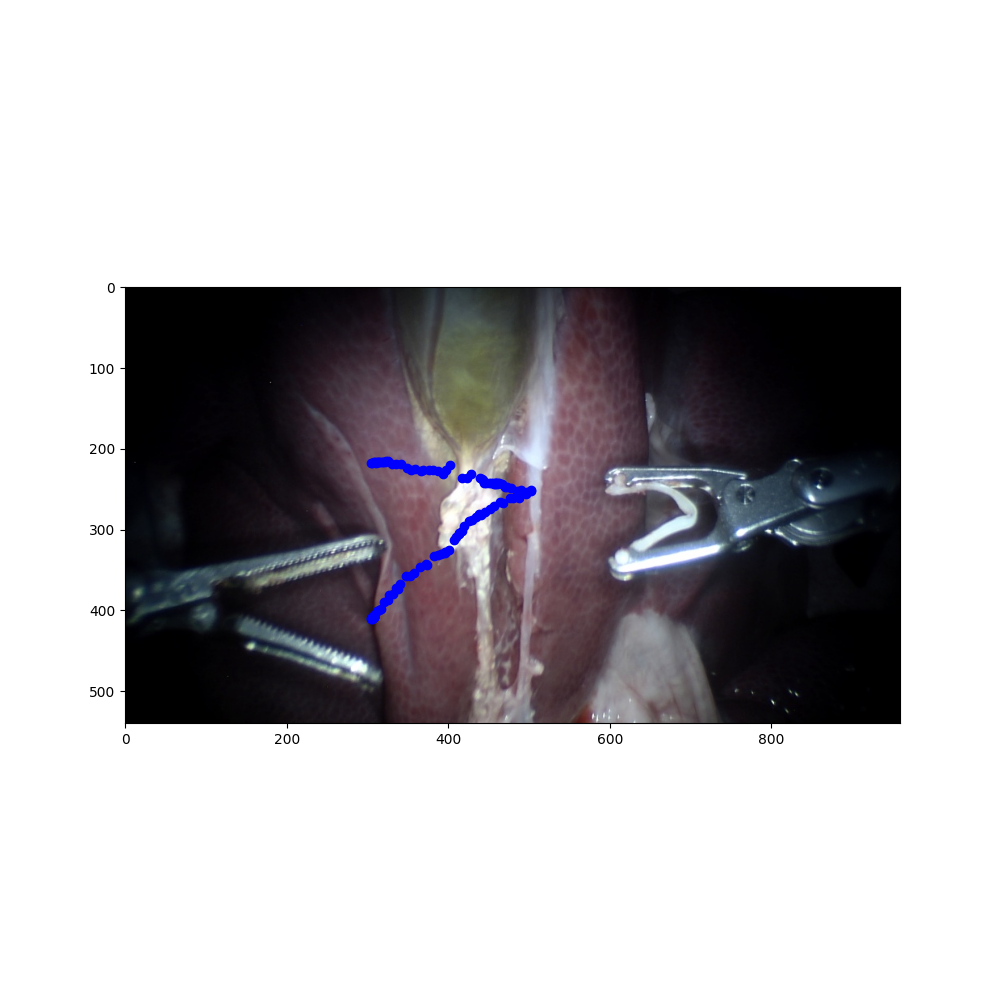

In [23]:
t_results = []

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# ax.imshow(original_image)
tool_poses_init = tool_poses[0]
print(tool_poses_init[0], tool_poses_init[1])
scale = 960/256
offset = (original_image_width - original_image_height) /2
starting_point = [tool_poses_init[0] * scale, tool_poses_init[1] * scale]
print(starting_point[0], starting_point[1] - offset)
# starting_point = [298.73125, 398.9125]
# starting_point = tool_poses_init
ax.imshow(original_image)
for num in range(len(tool_poses)):
    tool_pose_x = scale * (tool_poses[num][0])# - tool_poses_init[0]) + starting_point[0]
    tool_pose_y = scale * (tool_poses[num][1]) - offset # - tool_poses_init[1]) + starting_point[1]
    t_results.append([tool_pose_x, tool_pose_y])
    ax.scatter(tool_pose_x, tool_pose_y, c="b")

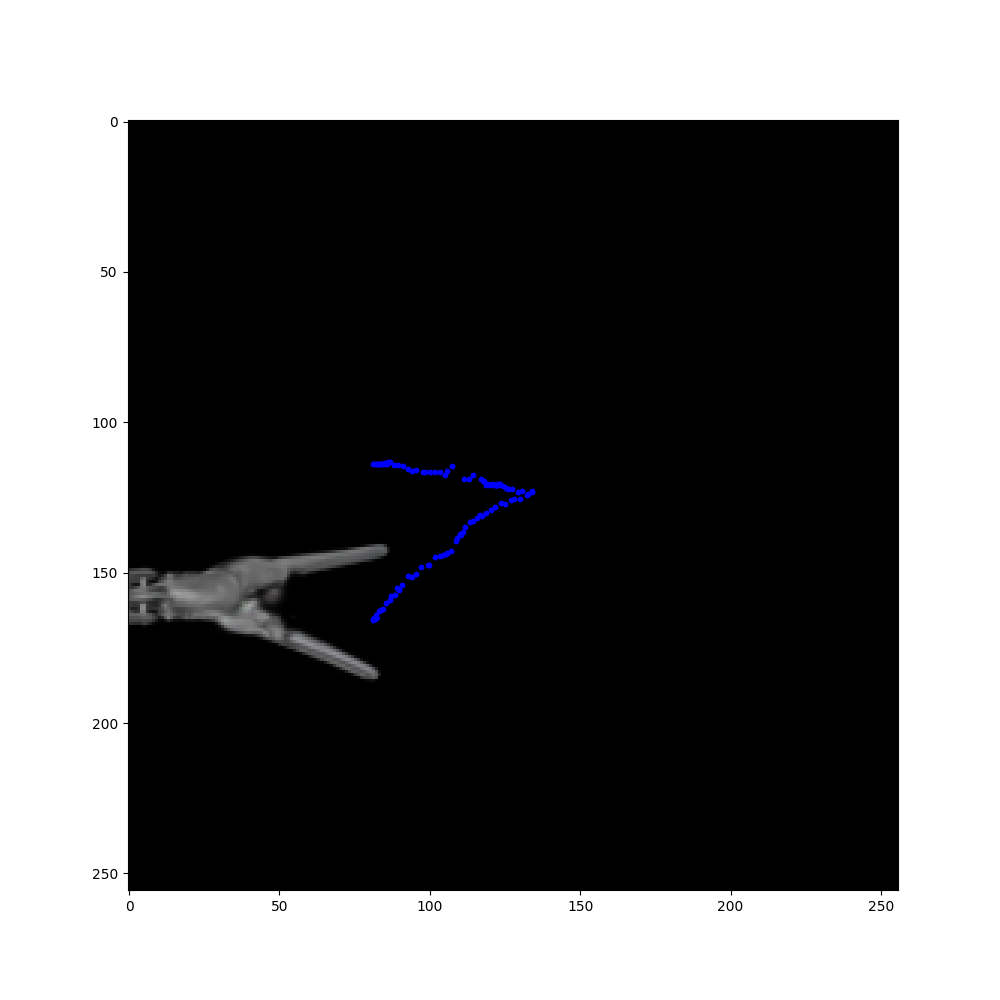

In [24]:

starting_point = tool_poses_init
# starting_point = [30, 160]
scale = 1
tool_poses_init = tool_poses[0]

# scale = 256/960
fig = plt.figure(figsize=(10, 10))

def display_render_traj(image_tensor: torch.Tensor, tool_poses: list = None):
    pose_results = []
    im = image_tensor.detach().permute(1, 2, 0).cpu().numpy()
    im = (im * 255).astype(np.uint8)
    plt.imshow(im)
    for num in range(len(tool_poses)):
        tool_pose_x = scale * (tool_poses[num][0] - tool_poses_init[0]) + starting_point[0]
        tool_pose_y = scale * (tool_poses[num][1] - tool_poses_init[1]) + starting_point[1]
        plt.scatter(tool_pose_x, tool_pose_y, c="b", s=10)
        pose_results.append([tool_pose_x, tool_pose_y])
    # plt.axis('off')
    plt.show()
    return pose_results


pose_results = display_render_traj(videos[0], tool_poses)


In [25]:
# # for num in range(len(tool_poses)):
# #     tool_pose_x = scale * (tool_poses[num][0] - tool_poses[0][0]) + starting_point[0]
# #     tool_pose_y = scale * (tool_poses[num][1] - tool_poses[0][1]) + starting_point[1]
# #     pose_results.append([tool_pose_x, tool_pose_y])

# def display_render_traj_frame(image_tensor: torch.Tensor, pose_results: list):
#     im = image_tensor.detach().permute(1, 2, 0).cpu().numpy()
#     im = (im * 255).astype(np.uint8)
#     fig, ax = plt.subplots(figsize=(5, 5))
#     ax.imshow(im)
#     # Plot the trajectory
#     for n in range(len(pose_results)):
#         tool_pose_x = pose_results[n][0]
#         tool_pose_y = pose_results[n][1]
#         ax.scatter(tool_pose_x, tool_pose_y, c="r", s=10)
#     plt.axis('off')
#     fig.canvas.draw()
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     plt.close(fig)
#     return image

# # Generate the GIF frames
# frames = []
# for frame_tensor in videos:
#     frame = display_render_traj_frame(frame_tensor, pose_results)
#     frames.append(frame)

# # Save the GIF
# filename = "./trajectory_render"
# clip = ImageSequenceClip(list(frames), fps=30)
# clip.write_gif(f"{filename}.gif")
# print(f"GIF saved at: {filename}")

[298.73125 398.9125 ]


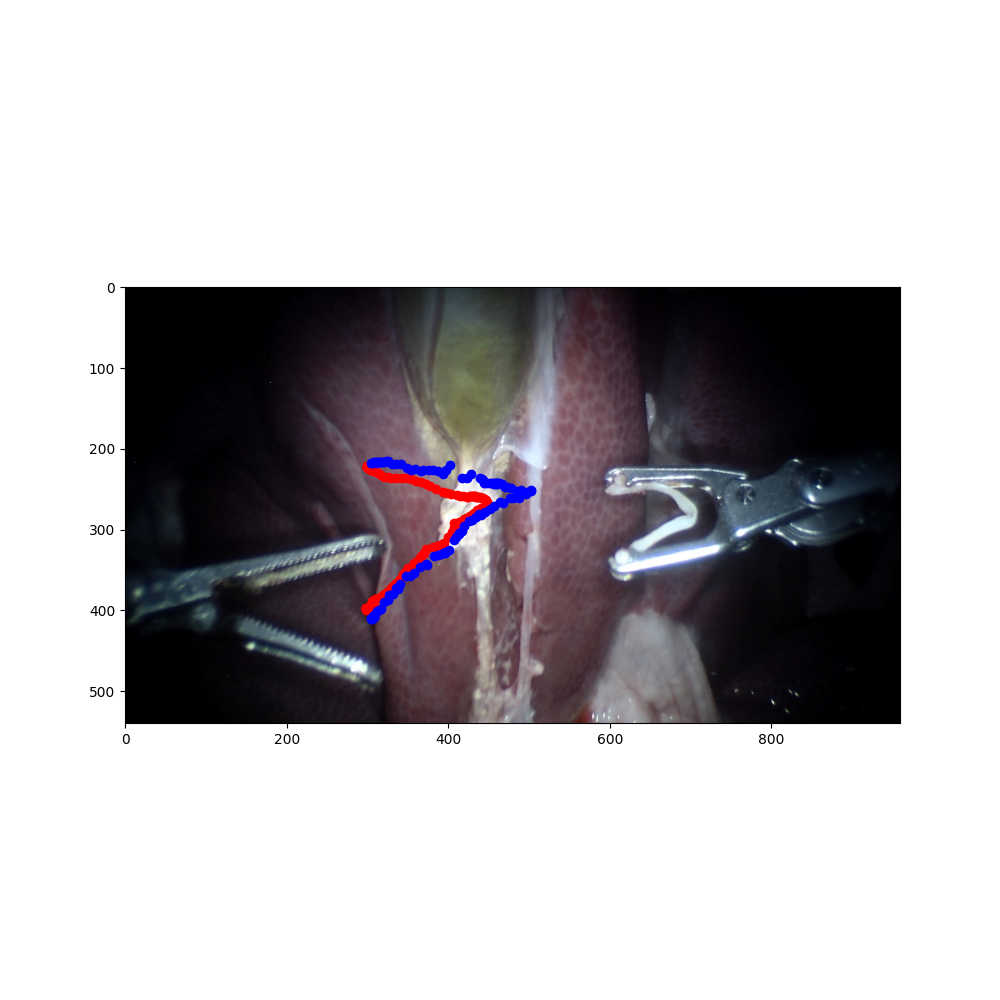

In [26]:
ee_label_path = "/home/iulian/chole_ws/data/base_chole_clipping_cutting/tissue_18/1_grabbing_gallbladder_recovery/20240719-160046-708534_recovery/ee_labels.csv"
ee_label = pd.read_csv(ee_label_path)
ee_label = ee_label[["ee_PSM2_x", "ee_PSM2_y"]].to_numpy()
ee_init = ee_label[0]
# ee_label = (ee_label - ee_init)
print(ee_init)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(original_image)

for a in ee_label:
    ax.scatter(a[0], a[1], c="r")

for a in t_results:
    ax.scatter(a[0], a[1], c="b")

plt.show()

Mean reprojection error: 22.422208607827166


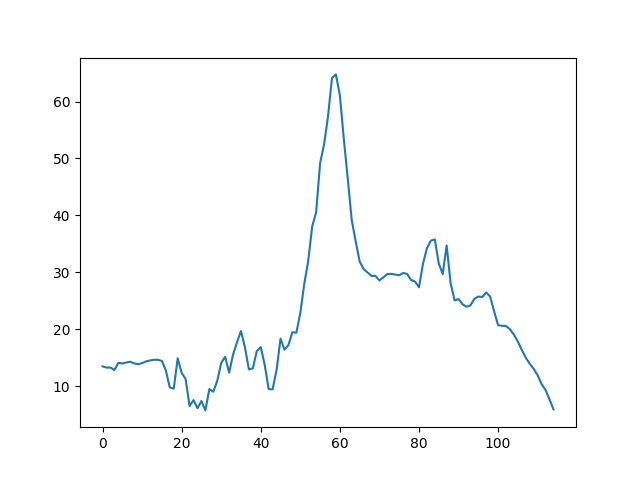

In [27]:




## use ee_label and t_results to calculate reprojection error
rep_error = []
for n in range(len(ee_label)):
    error = np.linalg.norm(ee_label[n] - t_results[n])
    rep_error.append(error)
    # print(f"Frame {n}: {np.linalg.norm(ee_label[n] - t_results[n])}")

## calculate the mean reprojection error
mean_rep_error = np.mean(rep_error)
print(f"Mean reprojection error: {mean_rep_error}")

fig = plt.figure()
plt.plot(rep_error)




[-0.03569732 -0.02360406  0.10166868]


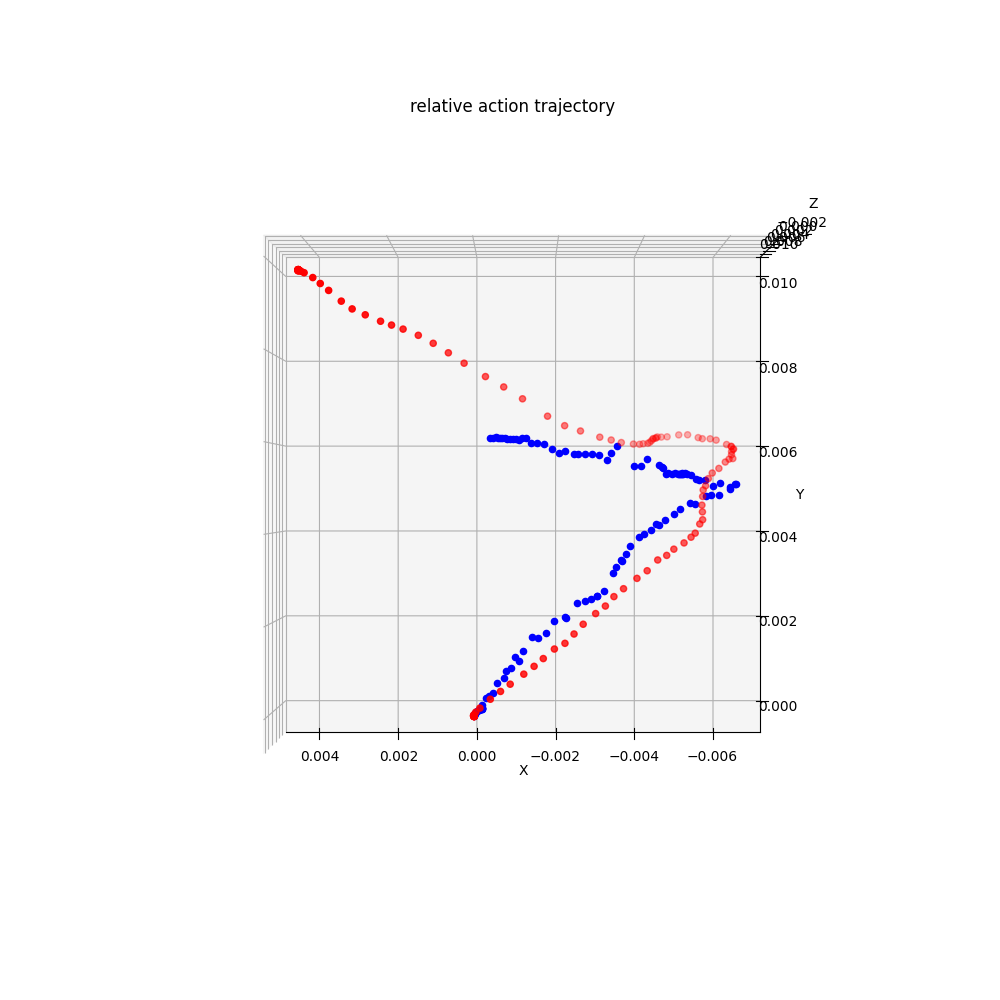

In [35]:
## read the csv file
ee_csv_path = "/home/iulian/chole_ws/src/sam2/data/tissue_18/grab/ee_csv.csv"
ee_csv = pd.read_csv(ee_csv_path)
header_name_qpos_psm1 = ["psm1_pose.position.x", "psm1_pose.position.y", "psm1_pose.position.z",
                        "psm1_pose.orientation.x", "psm1_pose.orientation.y", "psm1_pose.orientation.z", "psm1_pose.orientation.w",
                        "psm1_jaw"]

header_name_qpos_psm2 = ["psm2_pose.position.x", "psm2_pose.position.y", "psm2_pose.position.z",
                        "psm2_pose.orientation.x", "psm2_pose.orientation.y", "psm2_pose.orientation.z", "psm2_pose.orientation.w",
                        "psm2_jaw"]

ee_l_qpos = ee_csv[header_name_qpos_psm2].to_numpy()
ee_l_qpos_init = ee_l_qpos[0]
## normalize the data (substract with the initial pose)
ee_l_qpos_relative = ee_l_qpos - ee_l_qpos_init
results = []
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

trans_init = [T_tc_list[0][0], T_tc_list[0][1] , T_tc_list[0][2]]
print(ee_l_qpos_init[:3])
# print(trans_init)
# print(T_tc_list[0])
# print(T_tc_list - T_tc_list[0])

count = 0
# scale = 256/960
for r in T_tc_list:
    res = scale * (T_tc_list[0] - r)
    results.append([res[0], res[1], res[2]])
    ax.scatter(res[0], res[1], res[2], c="b")
    # count += 1
    # if count>50: 
        # break
# # plt.show()
# ax = fig.add_subplot(121, projection='3d')
ax.scatter(ee_l_qpos_relative[:, 0], ee_l_qpos_relative[:, 1], ee_l_qpos_relative[:, 2], c="r")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
## look from the top
ax.view_init(-90, 90)
# ax.view_init(0, 0)
## set title
plt.title("relative action trajectory")
# ax.legend(["robot", "human"])
plt.show()
# print(results)

In [29]:
# ## project the 3d points to 2d image
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111)
# ax.imshow(original_image)
# # Set up rasterization configuration
# tanfovx = math.tan(example_camera.FoVx * 0.5)
# tanfovy = math.tan(example_camera.FoVy * 0.5)

# focal_length_x = example_camera.image_width / (2 * tanfovx)
# focal_length_y = example_camera.image_height / (2 * tanfovy)
# K = torch.tensor(
#     [
#         [focal_length_x, 0, example_camera.image_width / 2.0, 0],
#         [0, focal_length_y, example_camera.image_height / 2.0, 0],
#         [0, 0, 1, 0],
#         [0, 0, 0, 1],
#     ],
#     device="cuda",
# )

# ## use projection matrix to project the 3d points to 2d image
# # P = K.inverse()
# P = sample_cameras[3].projection_matrix
# # P[0,2] = 0
# # P[1,2] = 0
# # P[2,0] = original_image_width / 2
# # P[2,1] = original_image_height / 2
# print(P.T)
# ee_projected = []
# scale = 960/256
# ee_l_qpos_transform = ee_l_qpos
# for n in range(len(ee_l_qpos)):

#     T_ee_homogeneous = torch.cat([torch.tensor(ee_l_qpos_transform[n][:3], device='cuda:0'), torch.tensor([1.0], device='cuda:0')])
#     print(T_ee_homogeneous)
#     # print(ee_l_qpos_transform[n][:3])
#     projected_pose = P.T.detach().cpu().numpy() @ T_ee_homogeneous[:4].detach().cpu().numpy()
#     x_2d = ((projected_pose[0] / projected_pose[2] + 1) * 0.5) * original_image_width
#     y_2d = ((projected_pose[1] / projected_pose[2] + 1) * 0.5) * original_image_width
#     ee_projected.append([x_2d, y_2d])
#     ax.scatter(x_2d, y_2d, c="b")
#     ax.scatter(t_results[n][0], t_results[n][1], c="r")



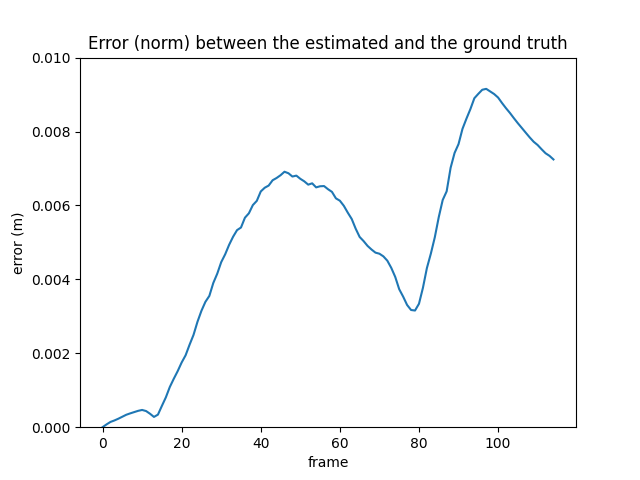

In [30]:
## plot error between the estimation and the ground truth
errors = []

n = 3
for i in range(len(ee_l_qpos_relative)):
    error = np.linalg.norm(ee_l_qpos_relative[i, :n] - results[i][:n])

    errors.append(error)

# print(np.linalg.norm(ee_l_qpos[:, :n], axis=1))
fig = plt.figure()
plt.plot(errors)
# plt.plot(np.linalg.norm(ee_l_qpos[:, :n], axis=1), 'r')
plt.xlabel("frame")
plt.ylabel("error (m)")
plt.ylim(0, 0.01)
plt.title("Error (norm) between the estimated and the ground truth")
plt.show()

